### Step 1 - Load Data

[28.105569, 28.105569, 28.106527, 28.130404, 28.109243]


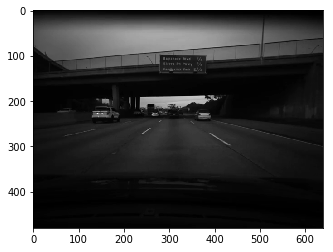

In [83]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
%matplotlib inline

speed_list = list(map(float,open("data/train.txt").read().splitlines()))
cap = cv2.VideoCapture('data/train.mp4')
ret, frame1 = cap.read()
ret, frame2 = cap.read()
cap.release()
cv2.destroyAllWindows()

gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
plt.imshow(gray1,cmap = 'gray')
print(speed_list[:5])


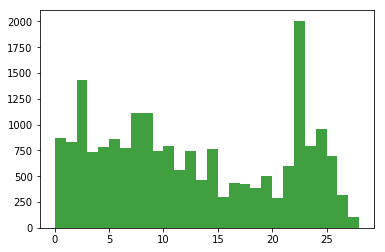

In [84]:
rounded = [round(speed) for speed in speed_list]
mn = 50
mx = 0
for num in rounded:
    mx = max(mx,num)
    mn = min(mn,num)
    
buckets = []
plt.hist(rounded, mx-mn, facecolor='g', alpha=0.75)
plt.show()

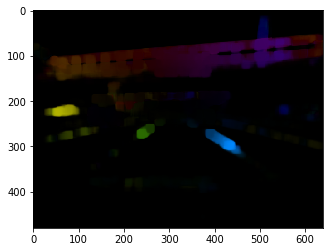

In [85]:
def opt_flow(frame1,frame2):
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255
    gray1 = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1,gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

rgb = opt_flow(frame1,frame2)
plt.imshow(rgb)

### Step 2: Data Augmentation

In [ ]:
#TODO Data Augmentation'

#Static Strings
directory = "data/processed/optflow-"
filetype = ".jpg"

#Init Video
cap = cv2.VideoCapture('data/train.mp4')
ret, prev = cap.read()
height , width , layers =  prev.shape
i = 0 

while(cap.isOpened()):
    ret, cur = cap.read()
    
    if ret == True:
        cv2.imwrite(directory+str(i)+filetype,opt_flow(prev,cur))
    else:
        break
    
    if i%100 == 0:
        print(i)
        
    i+=1
    prev = cur


cap.release()

In [86]:
def rotate(img,angle):
    rows, cols, layers = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(img,M,(cols,rows))

def flip(img):
    return cv2.flip(img,1)

def crop(img,maxh,minh):
    copy = img[:,:,:]
    return copy[minh:maxh,:]

def resize(img,w,h):
    resized_image = cv2.resize(img, (w, h))
    return resized_image

90 160


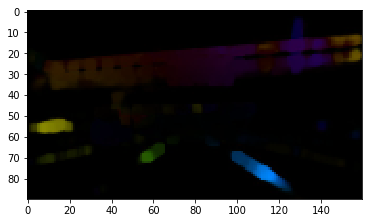

In [87]:
img = cv2.imread('data/processed/optflow-1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(crop(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),360,0),(160,90))#,interpolation = cv2.INTER_LANCZOS4)
rows, cols , layers = img.shape
print(rows,cols)
plt.imshow(img)

In [280]:
num_images = 2004
images = []
for i in range(num_images):
    images.append(directory+str(i)+filetype)
    
    

import sklearn
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(images, test_size=0.2)


validation_data = validation_data[:len(validation_data)-1]

print(len(validation_data))

400


### Step 3: Generator

In [281]:
def get_img_num(filename):
    return int(str(filename).split('-')[1].split('.')[0])


print(get_img_num("a-1.c"))

num_aug = 2

def generator(speed_list,image_names, batch_size=10*num_aug):
    
    angles = np.arange(-6,7,3)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(image_names)
        # batch_size/10 because for each row we add 10 images
        for offset in range(0, len(image_names), int(batch_size/num_aug)):
            batch_lines = image_names[offset:offset+int(batch_size/num_aug)]
                        
            images = []
            speeds = []
            
            for batch_line in batch_lines:
                img_num = get_img_num(batch_line)
                img = cv2.resize(crop(cv2.cvtColor(cv2.imread(batch_line),cv2.COLOR_BGR2RGB),360,0),(160,90))
                flipped = flip(img)
                
                images.append(img)
                images.append(flipped)
                speeds.append(speed_list[img_num])
                speeds.append(speed_list[img_num])
                
                """
                for angle in angles:
                    images.append(rotate(img,angle))
                    speeds.append(speed_list[img_num])
                    images.append(rotate(flipped,angle))
                    speeds.append(speed_list[img_num])
                """
                    
                    
            X_train = np.array(images)
            y_train = np.array(speeds)
            yield sklearn.utils.shuffle(X_train, y_train)

            
def valid_gen(speed_list,image_names, batch_size=10):
    
    while 1:
        for offset in range(0, len(image_names), int(batch_size)):
            batch_lines = image_names[offset:offset+int(batch_size)]
            
            images = []
            speeds = []
            
            for batch_line in batch_lines:
                img_num = get_img_num(batch_line)
                img = cv2.resize(crop(cv2.cvtColor(cv2.imread(batch_line),cv2.COLOR_BGR2RGB),360,0),(160,90))
                
                images.append(img)
                speeds.append(speed_list[img_num])
            
            X_valid = np.array(images)
            y_valid = np.array(speeds)
            yield sklearn.utils.shuffle(X_valid, y_valid)
            
            
    

1


In [282]:


#X_data,y_data = next(train_generator)
#print(X_data.shape,y_data.shape)
#plt.imshow(X_data[0])
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import ELU
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2

train_generator = generator(speed_list,train_data)
validation_generator = generator(speed_list,validation_data)

In [ ]:
input_shape = (90,160,3)
model = Sequential()

model.add(Lambda(lambda x: x / 255 - 0.5, input_shape = input_shape))
#model.add(Cropping2D(cropping = ((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample = (2,2),activation = "elu"))
model.add(Convolution2D(36,5,5,subsample = (2,2),activation = "elu"))
model.add(Convolution2D(48,5,5,subsample = (2,2),activation = "elu"))
model.add(Convolution2D(64,3,3,activation = "elu"))
model.add(Convolution2D(64,3,3,activation = "elu"))

model.add(Flatten())
model.add(Dense(100 , activation='elu'))
model.add(Dense(50,  activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_data)*num_aug, validation_data = validation_generator, nb_val_samples=len(validation_data),nb_epoch=10)

model.save('models/nvidia.h5')

In [ ]:

model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dense(100 , activation='elu'))
model.add(Dense(50,  activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_data)*num_aug, validation_data = validation_generator, nb_val_samples=len(validation_data),nb_epoch=20)
model.save('models/comma.h5')
